<a href="https://colab.research.google.com/github/DashtagGovender/Mini-project-COMP702/blob/Plant-Classification/PlantClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageEnhance

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Import and Access Image Contents

Threshold value:72.0


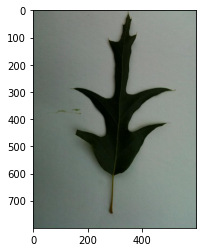

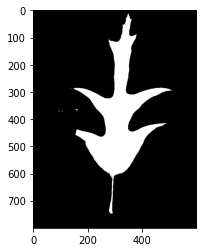

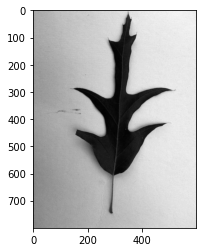

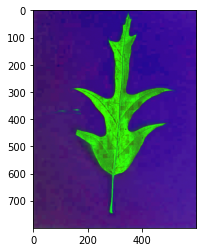

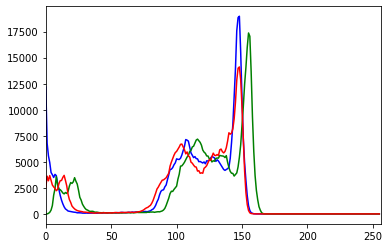

In [26]:
''' This code gives a simple demonstration of how thresholding and gray scaling
    may be done on an image using opencv and matplot. We also drew a graph to
    show the greylevel intensities of blue, green and red. However, there was no
    need for this since our images were given to us segmented on Leafsnap. '''

img = cv2.imread('/content/drive/MyDrive/Plant Classification/DATASET MAIN/Testing Set/Samples/12992006496821.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

''' It may also be suitable to obtain an HSV image, then increase it's hue for
    better thresholding. I didn't do this step, but I wanted to demonstrate
    this capability. '''
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#OTSU tries to maximise the interclass variance, it finds the optimal Threshold value
#ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#The OTSU METHOD uses a probabilistic method to isolate the object.
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure("Original")
plt.imshow(img_color)

print('Threshold value:' + str(ret))

plt.figure("Otsu Thresholding")
plt.imshow(thresh, cmap="gray")

plt.figure("GrayScale")
plt.imshow(gray, cmap="gray")

plt.figure("HSV")
plt.imshow(img_HSV)

plt.show()

# Histogram of blue, green, red ratio

color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

Equalise the Histogram of the Image

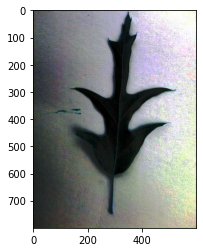

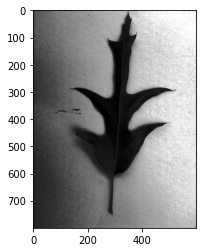

In [22]:
''' If needed we could have equalised the histogram, but as you can see
    equalising the histogram decreases the gap between greyscale pixels
    belonging to the image and greyscale pixels belonging to the background;
    this is bad for segmentation. '''

def histogram_equalization(img_in):
  # segregate color streams
    b,g,r = cv2.split(img_in)
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])

  # calculate cdf    
    cdf_b = np.cumsum(h_b)  
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)
    
  # mask all pixels with value=0 and replace it with mean of the pixel values 
    cdf_m_b = np.ma.masked_equal(cdf_b,0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')
  
    cdf_m_g = np.ma.masked_equal(cdf_g,0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    cdf_m_r = np.ma.masked_equal(cdf_r,0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')

  # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]
  
    img_out = cv2.merge((img_b, img_g, img_r))
  # validation
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    return img_out

eImage = histogram_equalization(img)

plt.imshow(eImage)

gray = cv2.cvtColor(eImage, cv2.COLOR_BGR2GRAY)

plt.figure("Grayscale")
plt.imshow(gray, cmap="gray")

plt.show()

Boundary Detection

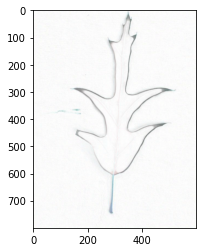

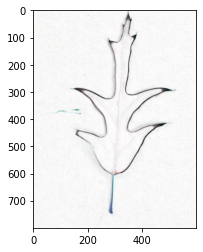

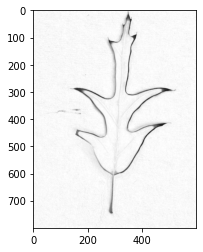

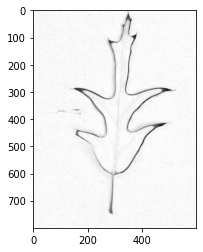

In [24]:
''' Over here, I wanted to demonstrate how we could determine the boundary of 
    our leaves, using dilation, median bluring and normalization. '''

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.figure("pResult")
plt.imshow(result)

plt.figure("pResult Normalized")
plt.imshow(result_norm)

gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray_result_norm = cv2.cvtColor(result_norm, cv2.COLOR_BGR2GRAY)

plt.figure("Result")
plt.imshow(gray_result, cmap="gray")

plt.figure("Result Normalized")
plt.imshow(gray_result_norm, cmap="gray")

Increase Image Contrast and Sharpen Image

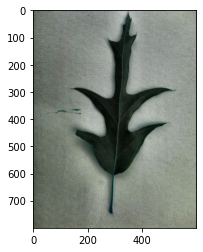

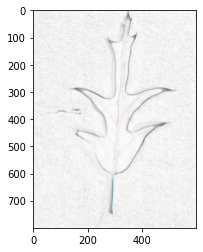

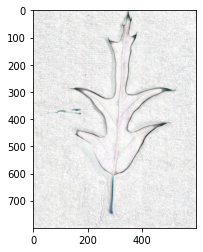

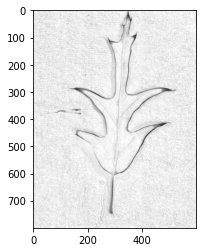

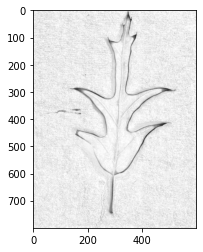

In [27]:
''' The goal of this step, is to show how image contrasting and sharpining can
    reveal finer details, such as the texture of the image. '''

#-----Converting image to LAB Color model----------------------------------- 
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
plt.imshow(l)
plt.imshow(a)
plt.imshow(b)

#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
plt.imshow(cl)

#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
plt.imshow(limg)

#-----Converting image from LAB Color model to RGB model--------------------
pImage = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
plt.imshow(pImage)

rgb_planes = cv2.split(pImage)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.figure("pResult")
plt.imshow(result)

plt.figure("pResult Normalized")
plt.imshow(result_norm)

gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray_result_norm = cv2.cvtColor(result_norm, cv2.COLOR_BGR2GRAY)

plt.figure("Result")
plt.imshow(gray_result, cmap="gray")

plt.figure("Result Normalized")
plt.imshow(gray_result_norm, cmap="gray")

#_____END_____#

Threshold the image for Segmentation

In [10]:
# Using this we can see the 3d array of the image
img

array([[[236, 244, 237],
        [236, 244, 237],
        [236, 244, 237],
        ...,
        [199, 204, 195],
        [199, 207, 197],
        [198, 206, 196]],

       [[236, 244, 237],
        [236, 244, 237],
        [236, 244, 237],
        ...,
        [198, 203, 194],
        [198, 206, 196],
        [198, 206, 196]],

       [[237, 243, 238],
        [237, 243, 238],
        [237, 243, 238],
        ...,
        [198, 203, 194],
        [197, 205, 195],
        [198, 206, 196]],

       ...,

       [[247, 253, 252],
        [248, 254, 253],
        [248, 254, 253],
        ...,
        [222, 236, 234],
        [222, 236, 234],
        [222, 236, 234]],

       [[248, 254, 253],
        [248, 254, 253],
        [249, 255, 254],
        ...,
        [222, 236, 234],
        [222, 236, 234],
        [222, 236, 234]],

       [[249, 255, 254],
        [249, 255, 254],
        [249, 255, 254],
        ...,
        [222, 236, 234],
        [223, 237, 235],
        [223, 237, 235]]

In [11]:
# This tells us our image size, image shape and dimension of the image array
img.size, img.shape, img.ndim

(1432800, (597, 800, 3), 3)

In [12]:
''' We can loop through all pixels of the image if needed, however we have
    libraries to help us out.'''
Nr, Ng, Nb = 0, 0, 0
for x in img:
  for y in x:
    Nr += y[0]
    Ng += y[1]
    Nb += y[2]
print(str(Nr) + ' ' + str(Ng) + ' ' + str(Nb))

82542023 89364788 85949451


Object Focusing

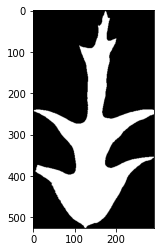

In [29]:
''' Over here, object detection and croping around an object region was 
    demonstrated, since our features don't focus on the size, but on
    the curvature of the object this step was not necessary. 
'''
import cv2  
import matplotlib.pyplot as plt
image = cv2.imread("/content/drive/MyDrive/Plant Classification/DATASET MAIN/Testing Set/Segmented/12992006496821.png")  
edged = cv2.Canny(image, 10, 250) 
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
idx = 0 
for c in cnts: 
	x,y,w,h = cv2.boundingRect(c) 
	if w>50 and h>50: 
		idx+=1 
		new_img=image[y:y+h,x:x+w] 
  # The imwrite function can be used to save a segmented image
	# cv2.imwrite('/content/drive/MyDrive/Plant Classification/DATASET MAIN/Testing Set/Segmented/' + str(idx) + '.png', new_img) 
plt.figure("Image")
plt.imshow(new_img, cmap="gray")